# Net EI impact of variance changes

This script joins data on the CO2 intensity of each unit and that unit's total generation over the baseline periods. Then, it calculates the change in emissions resulting from the different average capacity factors.

This answers the following question: 

> What would emissions have been from 2015 to 2017 if fossil-fired power plants still generated the way they did from 2006 to 2008?

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##### Join emssions intensity and summed generation

Read in data

In [22]:
CO2I = pd.read_csv('CO2I_change_LOWESS.csv')
gen = pd.read_csv('sumGen.csv')

How many plants have both before and after components? Have to drop those that don't

In [23]:
gen_full = gen.dropna()
gen_full.shape

(470, 4)

In [24]:
CO2I_full = CO2I.dropna()
CO2I_full.shape

(468, 4)

In [25]:
joined = CO2I.merge(gen, how='left', left_on=['ORISPL_CODE', 'UNITID'], right_on=['ORISPL_CODE', 'UNITID'])

In [26]:
joined.head()

,ORISPL_CODE,UNITID,CO2I_06_08,CO2I_15_17,gen_06_08,gen_15_17
0,87,1,1.037074,1.073461,5398410.18,3656639.48
1,113,1,1.122126,1.140871,2765392.93,1143207.63
2,113,2,1.101016,1.089972,6683196.25,1210852.47
3,113,3,1.111009,1.118695,6785225.42,3096860.17
4,113,4,1.063945,1.072063,8938559.84,6122842.37


Check for outliers

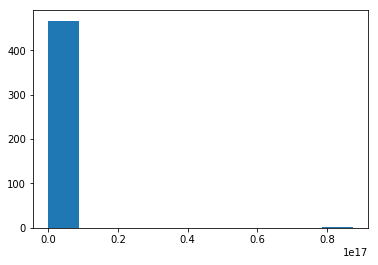

In [63]:
plt.hist(joined['CO2_15_17_hypo'])
plt.show()

In [62]:
joined['CO2_15_17_hypo'].idxmax()

262

In [58]:
joined.iloc[262,:]

ORISPL_CODE               10682
UNITID                      GT2
CO2I_06_08          2.08247e+13
CO2I_15_17          2.08247e+13
gen_06_08               15652.5
gen_15_17               4193.41
EI_diff                       0
CO2_15_17_actual    8.73263e+16
CO2_15_17_hypo      8.73263e+16
Name: 262, dtype: object

Clearly there is one huge outlier, resulting from wacky LOWESS fits. Let's drop that row.

In [67]:
joined.drop(joined['CO2_15_17_hypo'].idxmax(), axis=0, inplace=True)

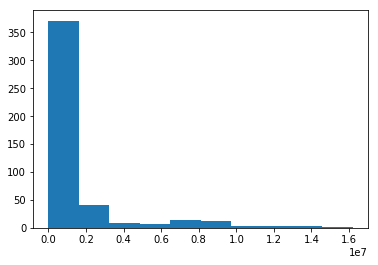

In [68]:
plt.hist(joined['CO2_15_17_hypo'])
plt.show()

It's much more reasonable that a plant could generate 1e6, or 0.1% of a GT in a year. Here's a quick calculation:

In [70]:
0.9*24*365*1.3*500  # (CF [])(hours/day)(days/year)(tonnes CO2/MWh)(MW capacity)

5124600.0

Are there any other ridiculous CO2I estimates?

In [89]:
(joined['CO2I_15_17'] > 3).any()

False

In [94]:
(joined['CO2I_06_08'] > 3).any()

True

Which?

In [96]:
crazies = joined[joined['CO2I_06_08'] > 3]
crazies

,ORISPL_CODE,UNITID,CO2I_06_08,CO2I_15_17,gen_06_08,gen_15_17,EI_diff,CO2_15_17_actual,CO2_15_17_hypo
67,399,**10B,5.404914,0.619678,321034.00,105513.54,-4.785236,65384.454851,570291.628315
99,2176,GT-2,3.619167,2.849612,17338.46,8607.75,-0.769555,24528.750250,31152.885177
382,55544,GT1,6.536667,0.559793,23213.72,35614.20,-5.976874,19936.574634,232798.154000


Let's eliminate these as well.

In [100]:
joined = joined[joined['CO2I_06_08'] < 3]

##### Caclulate what emissions would have been from '15-'17

In [101]:
joined['EI_diff'] = joined['CO2I_15_17'] - joined['CO2I_06_08']
joined['CO2_15_17_actual'] = joined['CO2I_15_17'] * joined['gen_15_17']
joined['CO2_15_17_hypo'] = joined['CO2I_06_08'] * joined['gen_15_17']

In [102]:
joined.head()

,ORISPL_CODE,UNITID,CO2I_06_08,CO2I_15_17,gen_06_08,gen_15_17,EI_diff,CO2_15_17_actual,CO2_15_17_hypo
0,87,1,1.037074,1.073461,5398410.18,3656639.48,0.036387,3.925258e+06,3.792205e+06
1,113,1,1.122126,1.140871,2765392.93,1143207.63,0.018745,1.304252e+06,1.282823e+06
2,113,2,1.101016,1.089972,6683196.25,1210852.47,-0.011044,1.319795e+06,1.333167e+06
3,113,3,1.111009,1.118695,6785225.42,3096860.17,0.007686,3.464441e+06,3.440638e+06
4,113,4,1.063945,1.072063,8938559.84,6122842.37,0.008119,6.564074e+06,6.514366e+06


What is the net difference in CO2?

In [103]:
netCO2_diff = (joined['CO2_15_17_actual'] - joined['CO2_15_17_hypo']).sum()
netCO2_diff

-4822072.7377317855

In [104]:
netCO2_diff = (joined['EI_diff'] * joined['gen_15_17']).sum()
netCO2_diff

-4822072.7377317855

Context: What percent of total (actual) generation is that?

In [105]:
totalGen_15_17 = joined['CO2_15_17_actual'].sum()
print('Total WI emissions: ', totalGen_15_17/1e9, 'GT')

Total WI emissions:  0.6814433385958861 GT


In [106]:
percentCO2 = 100 * (netCO2_diff / totalGen_15_17)
percentCO2

-0.7076263666569352

What's the significance of this number? CO2I actually decreased between '06-'08 and '15-'17. We saw there was little emissions overall, and the net effect was a __decrease in CO2I__, despite an __increase in power supply variability__.

A little more digestion:
1. How many plants increased their CO2I? How many decreased?
2. How much farther down the capacity factor scale can we hike before we see significant impacts?
3. Did coal or gas behave differently?

In [77]:
nIncreased = (joined['EI_diff'] > 0).sum()
print(nIncreased, 'plants increased their CO2I')
print(joined.shape[0] - nIncreased, 'plants decreased their CO2I')

246 plants increased their CO2I
222 plants decreased their CO2I
